#### Actividad - Proyecto práctico


> La actividad se desarrollará en grupos pre-definidos de 2-3 alumnos. Se debe indicar los nombres en orden alfabético (de apellidos). Se recuerda que esta actividad se corresponde con un 30% de la nota final de la asignatura. Se debe entregar entregar el trabajo en la presente notebook.
*   Alumno 1:
*   Alumno 2:
*   Alumno 3:
*   Alumno 4: 






### Entorno Acrobot-v1: dinámica, objetivo y criterio de éxito

**Descripción del entorno.** Acrobot es un sistema sub-actuado de dos eslabones con un único motor en la articulación central. El estado incluye senos y cosenos de los ángulos y sus velocidades angulares. El objetivo del agente es **elevar el extremo libre por encima de una altura umbral** (swing-up). [3]

**Recompensa.** En Acrobot-v1 la recompensa es $-1$ en cada paso mientras no se alcanza el objetivo, y $0$ cuando se logra. Por ello, maximizar la recompensa equivale a **minimizar el número de pasos** hasta el objetivo. El umbral de recompensa oficial es $-100$. [3]

**Finalización del episodio.** Un episodio termina cuando se alcanza la altura objetivo o cuando se llega al límite de pasos (500 pasos en v1). Por tanto, un episodio exitoso suele tener recompensa total mayor (menos negativa), e.g. $-100$ indica éxito en ~100 pasos, mientras que $-500$ indica no alcanzar la meta. [3]

**Criterio de la práctica.** La tarea exige **alcanzar el objetivo de altura durante 100 episodios de test consecutivos**. En esta implementación, el éxito se verifica cuando el episodio termina antes del límite de pasos.




### Objetivo geométrico (altura del extremo)

En **Acrobot-v1** el episodio termina con éxito cuando la **punta del segundo brazo** supera una **altura umbral** respecto al pivote.

En la implementación estándar (longitudes $l_1=l_2=1$), la altura del extremo libre se calcula como:

$\;h(θ_1,θ_2) = -\cos(θ_1) - \cos(θ_1 + θ_2)$

y el objetivo es **$h > 1.0$**. En otras palabras, la punta debe quedar **por encima de la línea horizontal** ubicada a una unidad de altura sobre el pivote. [3]


Altura h = 1.00 (éxito si h > 1.0)


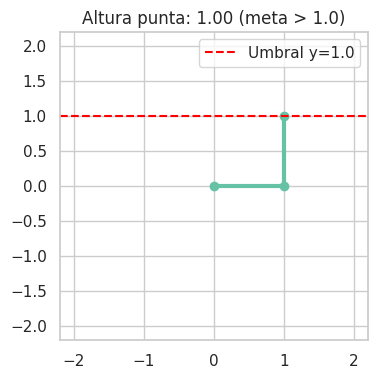

0.9999999999999999

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def tip_height(theta1, theta2, l1=1.0, l2=1.0):
    return -l1 * np.cos(theta1) - l2 * np.cos(theta1 + theta2)

def plot_acrobot(theta1, theta2, l1=1.0, l2=1.0, goal=1.0):
    # Posiciones de las articulaciones
    x0, y0 = 0.0, 0.0
    x1 = l1 * np.sin(theta1)
    y1 = -l1 * np.cos(theta1)
    x2 = x1 + l2 * np.sin(theta1 + theta2)
    y2 = y1 - l2 * np.cos(theta1 + theta2)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.plot([x0, x1, x2], [y0, y1, y2], '-o', lw=3)
    ax.axhline(goal, color='red', linestyle='--', label=f'Umbral y={goal}')
    ax.set_aspect('equal', 'box')
    ax.set_xlim(-2.2, 2.2)
    ax.set_ylim(-2.2, 2.2)
    ax.set_title(f'Altura punta: {y2:.2f} (meta > {goal})')
    ax.legend()
    plt.show()
    return y2

# Ejemplo ilustrativo (ajusta θ_1, θ_2 si deseas)
theta1 = np.pi / 2  # 90°
theta2 = np.pi / 2  # 90°
h = tip_height(theta1, theta2)
print(f'Altura h = {h:.2f} (éxito si h > 1.0)')
plot_acrobot(theta1, theta2)


---
## **PARTE 1** - Entorno de trabajo con Docker (local)

En este proyecto se trabaja en un entorno **dockerizado** para asegurar reproducibilidad: misma versión de Python (3.8), mismas dependencias y mismo comportamiento en cualquier equipo. Además, el entrenamiento se ejecuta en **CPU** porque Acrobot es un entorno de **estado de baja dimensión** y el DQN utiliza una **MLP pequeña** (un par de capas densas) suficiente para aproximar $Q(s,a)$ en tareas de control clásico; en esta escala el coste computacional es bajo y no compensa la complejidad de GPU [1].

Para la visualización sin GUI se usa el modo `rgb_array` del entorno y generamos un MP4 a partir de los frames [1]. A continuación se describen los pasos para construir el entorno, ejecutar Jupyter Lab y entrenar/evaluar dentro del contenedor.


---
### 1.1. Construcción de la imagen Docker

La imagen se define en `docker/Dockerfile` y fija Python 3.8 junto con todas las dependencias del proyecto. Esto evita incompatibilidades entre equipos y permite repetir los resultados en cualquier máquina.

Se construye la imagen (solo la primera vez o cuando se cambien dependencias) utilizando el siguiente comando:
```bash
docker compose build
```


---
### 1.2. Jupyter Lab en Docker

El servicio `jupyter` del `docker-compose.yml` expone el puerto 8888 y monta el repositorio en `/workspace`.

Para poder renderizar y generar video sin entorno gráfico, se levanta un **display virtual** (Xvfb) y se definen las variables:
- `PYGLET_HEADLESS=1`: activa el modo headless de `pyglet` (no intenta abrir una ventana real).
- `SDL_VIDEODRIVER=dummy`: usa un backend de video falso para entornos sin pantalla.
- `DISPLAY=:99`: apunta al display virtual creado por Xvfb (el número 99 es el identificador del display).

El servicio se inicia así:
```bash
docker compose up jupyter
```

Se abre el navegador en:
```
http://localhost:8888/lab?token=TU_TOKEN
```
El token aparece en la salida del comando. Para detener el servicio, se usa `Ctrl+C`.


---
### 1.3. Entrenamiento y evaluación (Docker)

El entrenamiento y la evaluación se ejecutan dentro del contenedor usando los scripts del proyecto. Se dispone de tres comandos principales:

El archivo `config.yaml` se usa para **modificar hiperparámetros directamente** (red, entrenamiento, exploración, etc.), lo que permite controlar y comparar mejoras del modelo desde un único punto de configuración.

**1) Entrenamiento**
```bash
./docker_train.sh configs/dqn_base.yaml dqn_base_01
```
- `configs/dqn_base.yaml`: archivo de configuración con hiperparámetros (entorno, red, training, etc.).
- `dqn_base_01`: identificador del run; se usa para nombrar carpetas y archivos de salida.

**2) Evaluación**
```bash
./docker_eval.sh outputs/runs/dqn_base_01/config.yaml outputs/weights/dqn_base_01_weights.h5 100 dqn_base_01
```
- `outputs/runs/dqn_base_01/config.yaml`: misma configuración usada en entrenamiento.
- `outputs/weights/dqn_base_01_weights.h5`: pesos del modelo entrenado.
- `100`: número de episodios de test.
- `dqn_base_01`: si se indica, guarda métricas y figuras en `outputs/runs/dqn_base_01/`.

**3) Entrenamiento + evaluación**
```bash
./docker_train_eval.sh configs/dqn_base.yaml dqn_base_01 100
```
- `configs/dqn_base.yaml`: configuración base.
- `dqn_base_01`: identificador del run.
- `100`: episodios de evaluación al terminar el entrenamiento.

Los resultados quedan en `outputs/runs/<run_id>/` (config, logs, métricas y figuras) y los pesos en `outputs/weights/`.


---
### 1.4. Estructura de directorios y clases

La organización del proyecto separa configuración, scripts, código y salidas de forma reproducible:

```text
08MIAR_PROYECTO/
├─ configs/                 # Configuración de experimentos (YAML)
├─ docker/                  # Dockerfile y documentación
├─ scripts/                 # Entrypoints CLI (train/eval)
├─ src/
│  └─ acrobot_dqn/           # Implementación principal DQN
│     ├─ agent.py            # Agente DQN y políticas
│     ├─ eval.py             # Evaluación
│     ├─ model.py            # Arquitectura de red
│     ├─ plots.py            # Gráficas
│     ├─ render.py           # Video MP4 headless
│     ├─ trainer.py          # Entrenamiento
│     └─ utils.py            # Utilidades (config, seeds)
├─ outputs/                 # Runs, métricas, figuras, pesos
├─ books/                   # Bibliografía
└─ references/              # Referencias en IEEE
```

**Clases principales (DQN):**
- `DQNModelBuilder` (`src/acrobot_dqn/model.py`): construye la MLP para aproximar $Q(s,a)$.
- `DQNAgentFactory` (`src/acrobot_dqn/agent.py`): crea el agente DQN con replay buffer, política $ε$‑greedy y variantes.
- `DQNTrainer` (`src/acrobot_dqn/trainer.py`): ejecuta el entrenamiento, guarda logs, checkpoints y figuras.
- `DQNEvaluator` (`src/acrobot_dqn/eval.py`): evalúa en episodios de test y guarda métricas/gráficas.
- `EpisodeVideoRecorder` (`src/acrobot_dqn/render.py`): genera MP4 desde `rgb_array` en modo headless.

**Módulos de soporte:**
- `plots.py`: utilidades para gráficas de entrenamiento y evaluación.
- `utils.py`: carga/guarda de configuración, semillas y gestión de directorios.

**Scripts (CLI):**
- `scripts/train.py`: entrena un run a partir de un `config.yaml`.
- `scripts/eval.py`: evalúa pesos entrenados y genera métricas/figuras.

Esta separación permite modificar hiperparámetros desde `configs/` sin tocar el código, y centraliza los resultados en `outputs/` para su análisis.


---
## **PARTE 2**. Enunciado

Consideraciones a tener en cuenta:

- El entorno sobre el que se trabajará será [Acrobot_V1](https://gymnasium.farama.org/environments/classic_control/acrobot/) y el algoritmo que se usará será _DQN_.

- Para este ejercicio, el requisito mínimo será **alcanzar el objetivo de altura durante 100 episodios de test consecutivos**. Por ello, esta media de la recompensa se calculará a partir del código de test en la última celda del notebook.

Este proyecto práctico consta de tres partes:

1.   Implementar la red neuronal que se usará en la solución
2.   Implementar las distintas piezas de la solución DQN
3.   Justificar la respuesta en relación a los resultados obtenidos

**Rúbrica**: Se valorará la originalidad en la solución aportada, así como la capacidad de discutir los resultados de forma detallada. El requisito mínimo servirá para aprobar la actividad, bajo premisa de que la discusión del resultado sera apropiada.

IMPORTANTE:

* Si no se consigue una puntuación óptima, responder sobre la mejor puntuación obtenida.
* Para entrenamientos largos, recordad que podéis usar checkpoints de vuestros modelos para retomar los entrenamientos. En este caso, recordad cambiar los parámetros adecuadamente (sobre todo los relacionados con el proceso de exploración).
* Se deberá entregar unicamente el notebook y los pesos del mejor modelo en un fichero .zip, de forma organizada.
* Cada alumno deberá de subir la solución de forma individual.

---
## **PARTE 3**. Desarrollo y preguntas

#### Importar librerías

In [17]:
import sys
from pathlib import Path
import json
import numpy as np
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, Video, HTML, display

ROOT = Path('.').resolve()
sys.path.append(str(ROOT / 'src'))

from acrobot_dqn.plots import plot_training_logs, plot_eval_results
from acrobot_dqn.utils import set_seeds
from acrobot_dqn.model import DQNModelBuilder
from acrobot_dqn.agent import DQNAgentFactory
from acrobot_dqn.render import EpisodeVideoRecorder


### Visualización del entorno (episodio aleatorio)

Para observar la dinámica del Acrobot sin GUI, se capturan frames con `rgb_array` y se codifican a MP4 [1].


In [18]:
ENV_NAME_RENDER = 'Acrobot-v1'
VIDEO_DIR = Path('outputs') / 'renders'
RANDOM_VIDEO = VIDEO_DIR / 'acrobot_random.mp4'

def random_policy(state, env):
    return env.action_space.sample()

recorder = EpisodeVideoRecorder(fps=30, max_steps=500, seed=42)
random_video_path = recorder.record(
    ENV_NAME_RENDER,
    policy_fn=random_policy,
    out_path=RANDOM_VIDEO,
)
print(f'Video guardado en: {random_video_path}')
display(Video(str(random_video_path), embed=True))


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x435ee380] Warning: data is not aligned! This can lead to a speed loss


Video guardado en: outputs/renders/acrobot_random.mp4


In [ ]:
# Hot reload de módulos locales (evita reiniciar kernel)
%load_ext autoreload
%autoreload 2


#### Configuración base

In [19]:
# Identificador del run que quieres reportar
RUN_ID = 'dqn_base_00'

RUN_DIR = Path('outputs') / 'runs' / RUN_ID
CONFIG_PATH = RUN_DIR / 'config.yaml'
EVAL_PATH = RUN_DIR / 'metrics' / 'eval.json'
FIG_DIR = RUN_DIR / 'figures'

if not CONFIG_PATH.exists():
    raise FileNotFoundError(f'No se encontro {CONFIG_PATH}. Asegura que el run existe.')

cfg = yaml.safe_load(CONFIG_PATH.read_text(encoding='utf-8'))
ENV_NAME = cfg.get('env_name', 'Acrobot-v1')
LOG_PATH = RUN_DIR / 'logs' / f'dqn_{ENV_NAME}_log.json'


In [20]:
# Resumen del modelo (si existe el .keras del run)
MODEL_PATH = Path('outputs') / 'weights' / f'{RUN_ID}_model.keras'
if MODEL_PATH.exists():
    try:
        import tensorflow as tf
        model = tf.keras.models.load_model(MODEL_PATH)
        model.summary()
    except Exception as e:
        print(f'No se pudo cargar el modelo: {e}')
else:
    print(f'No se encontro el modelo: {MODEL_PATH}')
    print('Resumen aproximado desde config:')
    print('Hidden units:', cfg.get('model', {}).get('hidden_units'))
    print('Activation:', cfg.get('model', {}).get('activation'))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 6)                 0         
                                                                 
 dense (Dense)               (None, 128)               896       
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 3)                 387       
                                                                 
Total params: 17,795
Trainable params: 17,795
Non-trainable params: 0
_________________________________________________________________


### Arquitectura de clases (resumen)

- **DQNModelBuilder**: define la arquitectura MLP para aproximar $Q(s,a)$.
- **DQNAgentFactory**: construye el agente DQN con replay buffer, política $\epsilon$-greedy y variantes.
- **DQNTrainer**: se ejecuta el entrenamiento, guarda logs, checkpoints y figuras.
- **DQNEvaluator**: evalúa en 100 episodios, guarda métricas y genera gráficas.


In [ ]:
def set_global_seeds(seed=SEED):
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_global_seeds(SEED)


1. Implementación de la red neuronal

La red para **Acrobot** no trabaja con píxeles, sino con el vector de estado continuo de 6 dimensiones. Por ello se utiliza una **MLP** sencilla que aproxima la función de valor de acción $Q_	heta(s,a)$, siguiendo la formulación de DQN [1]. En esta arquitectura, el estado se aplana y pasa por dos capas densas con activación ReLU; la salida produce un valor por acción discreta.

La elección de una MLP (en lugar de CNN) se justifica porque el espacio de observaciones no contiene estructura espacial, y el objetivo es aproximar $Q(s,a)$ de forma estable y eficiente [1], [2].


In [21]:
# Mostrar hiperparámetros usados en el run
config_df = pd.json_normalize(cfg, sep='.')
config_df = config_df.T.rename(columns={0: 'value'})

# Mostrar en dos columnas
mid = (len(config_df) + 1) // 2
left = config_df.iloc[:mid]
right = config_df.iloc[mid:]
html = f'''
<div style="display:flex; gap:16px; align-items:flex-start;">
  <div style="flex:1;">{left.to_html()} </div>
  <div style="flex:1;">{right.to_html()} </div>
</div>
'''
display(HTML(html))


,value
env_name,Acrobot-v1
seed,123
window_length,1
memory_limit,100000
run_id,dqn_base_00
model.hidden_units,"[128, 128]"
model.activation,relu
policy.eps_max,1.0
policy.eps_min,0.05
policy.eps_test,0.02


2. Implementación de la solución DQN

Se implementa DQN con: (i) **replay buffer** para romper correlaciones, (ii) política $\epsilon$-greedy con *annealing*, y (iii) *target network* opcionalmente actualizado cada cierto número de pasos, lo cual estabiliza el aprendizaje [1]. Las variantes **Double DQN** y **Dueling DQN** se activan con banderas, siguiendo las propuestas de estabilización y mejora del estimador de $Q$ descritas en [1].

La función objetivo se basa en el target de Bellman:

$$y(s,a)=r + \gamma \max_{a'} Q_{\theta^-}(s',a')$$

y la pérdida se minimiza típicamente con MSE o Huber:

$$\mathcal{L}(\theta)=\mathbb{E}\left[(y(s,a)-Q_{\theta}(s,a))^2\right].$$



In [22]:
# Graficas de entrenamiento (se generan a partir del log)
if LOG_PATH.exists():
    plot_training_logs(LOG_PATH, FIG_DIR)
    img_a = FIG_DIR / 'training_reward.png'
    img_b = FIG_DIR / 'training_mean_q.png'
    if img_a.exists() and img_b.exists():
        html = f'''
<div style="display:flex; gap:16px;">
  <div style="flex:1;"><img src="{img_a.as_posix()}" style="width:100%;"></div>
  <div style="flex:1;"><img src="{img_b.as_posix()}" style="width:100%;"></div>
</div>
'''
        display(HTML(html))
    else:
        for img_path in [img_a, img_b]:
            if img_path.exists():
                display(Image(filename=str(img_path)))
else:
    print(f'No se encontro el log: {LOG_PATH}')


In [23]:
# Cargar resultados de evaluación
if EVAL_PATH.exists():
    results = json.loads(EVAL_PATH.read_text(encoding='utf-8'))
    display(pd.DataFrame([{
        'successes': results.get('successes'),
        'success_rate': results.get('success_rate'),
        'mean_reward': results.get('mean_reward'),
    }]))
    plot_eval_results(results, FIG_DIR)
    img_a = FIG_DIR / 'eval_rewards.png'
    img_b = FIG_DIR / 'eval_rewards_hist.png'
    if img_a.exists() and img_b.exists():
        html = f'''
<div style="display:flex; gap:16px;">
  <div style="flex:1;"><img src="{img_a.as_posix()}" style="width:100%;"></div>
  <div style="flex:1;"><img src="{img_b.as_posix()}" style="width:100%;"></div>
</div>
'''
        display(HTML(html))
    else:
        for img_path in [img_a, img_b]:
            if img_path.exists():
                display(Image(filename=str(img_path)))
else:
    print(f'No se encontro el archivo: {EVAL_PATH}')


,successes,success_rate,mean_reward
0,100,1.0,-88.23


### Visualización de la política entrenada (episodio MP4)

Se graba un episodio con el agente entrenado usando el mismo mecanismo `rgb_array` y lo guardamos en MP4.


In [24]:
VIDEO_DIR = Path('outputs') / 'renders'
TRAINED_VIDEO = VIDEO_DIR / f'{RUN_ID}_policy.mp4'
WEIGHTS_PATH = Path('outputs') / 'weights' / f'{RUN_ID}_weights.h5'
ALT_WEIGHTS_PREFIX = Path('outputs') / 'weights' / f'{RUN_ID}_weights.h5f'
ALT_WEIGHTS_INDEX = Path(str(ALT_WEIGHTS_PREFIX) + '.index')

if not WEIGHTS_PATH.exists() and ALT_WEIGHTS_INDEX.exists():
    WEIGHTS_PATH = ALT_WEIGHTS_PREFIX

if not WEIGHTS_PATH.exists() and not ALT_WEIGHTS_INDEX.exists():
    print(f'No se encontro el archivo de pesos: {WEIGHTS_PATH}')
else:
    import gym
    tmp_env = gym.make(ENV_NAME)
    nb_actions = tmp_env.action_space.n
    obs_shape = tmp_env.observation_space.shape
    tmp_env.close()

    model = DQNModelBuilder(
        hidden_units=cfg.get('model', {}).get('hidden_units', [128, 128]),
        activation=cfg.get('model', {}).get('activation', 'relu'),
    ).build(obs_shape, nb_actions)
    agent = DQNAgentFactory(cfg).build(model, nb_actions)
    agent.load_weights(str(WEIGHTS_PATH))

    def dqn_policy(state, env):
        return agent.forward(state)

    def reset_agent():
        agent.reset_states()

    recorder = EpisodeVideoRecorder(fps=30, max_steps=500, seed=cfg.get('seed', 42))
    trained_video_path = recorder.record(
        ENV_NAME,
        policy_fn=dqn_policy,
        out_path=TRAINED_VIDEO,
        reset_fn=reset_agent,
    )
    print(f'Video guardado en: {trained_video_path}')
    display(Video(str(trained_video_path), embed=True))


/usr/local/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x352cb380] Warning: data is not aligned! This can lead to a speed loss


Video guardado en: outputs/renders/dqn_base_00_policy.mp4


3. Justificación de los parámetros seleccionados y de los resultados obtenidos

**Justificación del diseño**

- **Arquitectura MLP**: Acrobot provee un estado continuo de baja dimensión; por tanto, una MLP es suficiente para aproximar $Q(s,a)$ sin necesidad de convoluciones [1].
- **Replay buffer**: reduce correlación temporal entre muestras y mejora la estabilidad del aprendizaje [1].
- **Target network**: desacopla la red objetivo de la red online, reduciendo oscilaciones [1].
- **Double/Dueling DQN (opcional)**: Double DQN reduce la sobreestimación de $Q$; Dueling separa el valor del estado y la ventaja por acción [1].

**Resultados (completar con la ejecución real)**

- Recompensa media en test (100 episodios): ________
- Éxitos (meta alcanzada): ________/100
- Observaciones sobre estabilidad, velocidad de convergencia y sensibilidad a hiperparámetros.

**Referencias (IEEE)**

[1] A. Géron, *Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow*, 3rd ed., 2025, ch. 18.

[2] R. S. Sutton and A. G. Barto, *Reinforcement Learning: An Introduction*, 2nd ed., MIT Press, 2020.

[3] Farama Foundation, “Acrobot-v1,” *Gymnasium Documentation*, 2025. Disponible: https://gymnasium.farama.org/environments/classic_control/acrobot/


---